In [ ]:
!pip install sentence-transformers openai-clip

In [ ]:
!pip install faiss-cpu

In [1]:
import numpy 
import clip
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
import faiss
import cv2
from tqdm import tqdm

In [2]:
import torch
print(torch.__version__)

2.5.1+cpu


In [3]:
%cd "C:\Users\Dell\Documents\GitHub\Image-based-Recommendataion-System"

C:\Users\Dell\Documents\GitHub\Image-based-Recommendataion-System


In [4]:
df = pd.read_csv('./products/data.csv')
df.head()

,image,description,display name,category
0,3238.jpg,"Round toed, black sports shoes with red accent...",Puma Men Black 65CC Lo Ducati Sports Shoes,Sports Shoes
1,43044.jpg,Style Note Built with the breathability and ze...,Nike Men Charcoal Grey Shorts,Shorts
2,54018.jpg,Teal handbag that has stitch detailing with a...,Kiara Women Teal Handbag,Handbags
3,8141.jpg,"Perfectly stylish, this fastrack analog wrist ...",Fastrack Women Freestyle Sports Analog Steel B...,Watches
4,22245.jpg,These id mid-top chukka shoes add a fresh spin...,ID Men Brown Casual Shoes,Casual Shoes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         44441 non-null  object
 1   description   44160 non-null  object
 2   display name  44434 non-null  object
 3   category      44441 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


we're just going to take the category and images.. 

In [9]:
base = './products/data'

In [8]:
for root, dirs, files in os.walk(base):
    count = 0  
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  
            count += 1  
print(f'Total number of images: {count}')

Total number of images: 44441


In [9]:
df = df[['image', 'category']]  
df.head()

,image,category
0,3238.jpg,Sports Shoes
1,43044.jpg,Shorts
2,54018.jpg,Handbags
3,8141.jpg,Watches
4,22245.jpg,Casual Shoes


## CLIP Model:
The CLIP (Contrastive Language-Image Pre-training) model, developed by OpenAI, is a multi-modal vision and language model that maps images and text to the same latent space. Since we will use both image and text queries to search for images, we will use the CLIP model to embed our data

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [11]:
image = preprocess(Image.open(
    os.path.join(base, df['image'][0]))).unsqueeze(0).to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [12]:
with torch.no_grad():
    image_features = model.encode_image(image)

image_features.shape

torch.Size([1, 512])

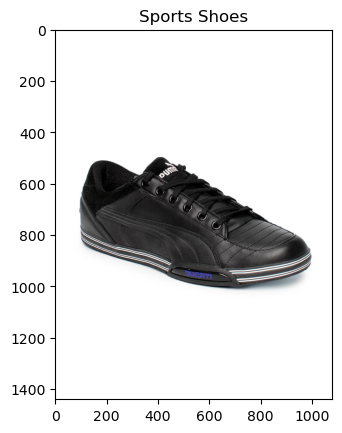

In [13]:
img = cv2.imread(os.path.join(base, df['image'][0]))

plt.title(df['category'][0])
plt.imshow(img)

In [14]:
c = df['category'][:4]
print(c)

text = clip.tokenize(c).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)

text_features.shape

0    Sports Shoes
1          Shorts
2        Handbags
3         Watches
Name: category, dtype: object


torch.Size([4, 512])

In [15]:

s = F.cosine_similarity(image_features, text_features, dim=1)

top_match = s.argmax().item()
print(f"The most similar category is: {c[top_match]}")

The most similar category is: Sports Shoes


In [16]:
def image_embeddings(image_path):

    img = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    with torch.no_grad():
        e = model.encode_image(img)
    
    return e

def text_embeddings(text):
    t = clip.tokenize([text]).to(device)
    
    with torch.no_grad():
        e = model.encode_text(t)
    
    return e

In [16]:
image_paths = [os.path.join(base, img) for img in df['image']]
print(len(image_paths))
text= [t for t in df['category']]

44441


In [24]:
image_paths[:3]

['./products/data\\3238.jpg',
 './products/data\\43044.jpg',
 './products/data\\54018.jpg']

In [18]:
text[:30]

['Sports Shoes',
 'Shorts',
 'Handbags',
 'Watches',
 'Casual Shoes',
 'Tshirts',
 'Wallets',
 'Tshirts',
 'Jeans',
 'Socks',
 'Dresses',
 'Shirts',
 'Watches',
 'Handbags',
 'Tshirts',
 'Watches',
 'Heels',
 'Tshirts',
 'Casual Shoes',
 'Kurtis',
 'Jackets',
 'Earrings',
 'Ties',
 'Tshirts',
 'Tunics',
 'Tshirts',
 'Sports Shoes',
 'Caps',
 'Formal Shoes',
 'Handbags']

In [23]:
image_embed = []
text_embed = []

for i, img in tqdm(enumerate(image_paths), total=len(image_paths), desc="Processing Images and Text"):
    image_embed.append(image_embeddings(img).squeeze().cpu().numpy())
    text_embed.append(text_embeddings(text[i]).squeeze().cpu().numpy())

Processing Images and Text: 100%|██████████| 10000/10000 [52:12<00:00,  3.19it/s] 


In [33]:
ie = np.vstack(image_embed).astype(np.float32)
te = np.vstack(text_embed).astype(np.float32)

In [34]:
dim = 512  ### CLIP produces embeddings with 512 dimensions
image_index = faiss.IndexFlatL2(dim) 
text_index = faiss.IndexFlatL2(dim) 

In [35]:
image_index.add(ie)
text_index.add(te)

In [36]:
faiss.write_index(image_index, "image_index.index")
faiss.write_index(text_index, "text_index.index")

In [13]:
image_i = faiss.read_index('image_index.index')
text_i = faiss.read_index('text_index.index')

In [14]:
def search(q=None, q_text=None, k=5):
    
    if q is not None:
        try:
            img = Image.open(q)
            q_i = preprocess(img).unsqueeze(0).to(device)
            with torch.no_grad():
                q_ie = model.encode_image(q_i).cpu().numpy()

            D_image, I_image = image_i.search(q_ie, k)

            results = []
            for i in range(k):
                results.append({
                    'image': image_paths[I_image[0][i]], 
                })
            return results

        except FileNotFoundError:
            print(f"Error: Image file '{q}' not found.")
            return []
        except Exception as e:
            print(f"Error processing image: {e}")
            return []

    elif q_text is not None:
        try:
            q_tt = clip.tokenize([q_text]).to(device)
            with torch.no_grad():
                q_te = model.encode_text(q_tt).cpu().numpy()

            D_text, I_text = text_i.search(q_te, k)

            results = []
            for i in range(k):
                results.append({
                    'image': image_paths[I_text[0][i]],  
                })
            return results

        except Exception as e:
            print(f"Error processing text: {e}")
            return []

    ### if neither image nor text is provided
    print("No valid query provided!")
    return []


## Example .1

In [35]:
q = os.path.join(base, df['image'][41300])
ex1 = search(q, k=5)

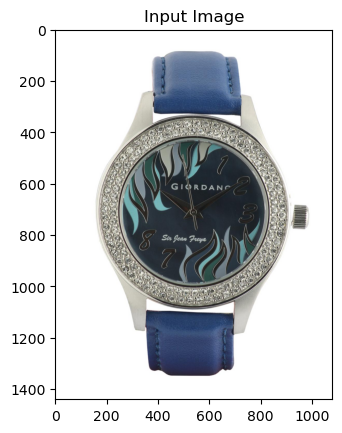

In [36]:
def plot(img):
    s = cv2.imread(img, cv2.IMREAD_COLOR)
    s = cv2.cvtColor(s, cv2.COLOR_BGR2RGB)
    plt.title('Input Image')
    plt.imshow(s)

plot(q)

In [42]:
def recommendations(r):
    fig, axes = plt.subplots(1, len(r), figsize=(15, 5))
    for i, k in enumerate(r):
        image_path = k['image']
        image = Image.open(image_path)
        
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()

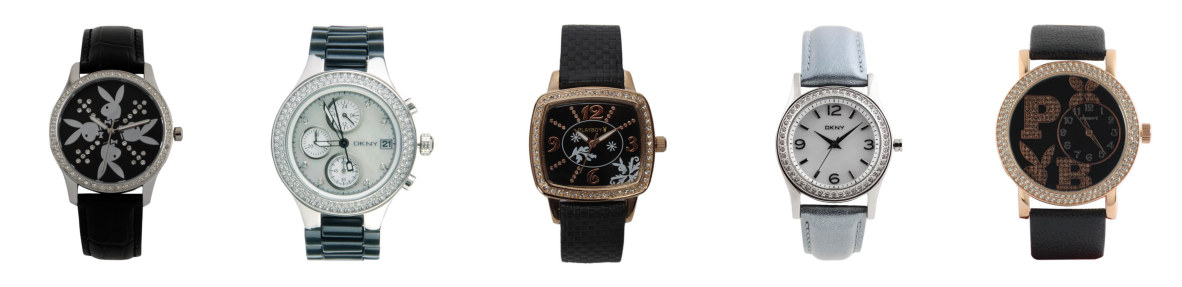

In [43]:
recommendations(ex1)

In [48]:
q_text = 'handbags'
ext1 = search(q_text=q_text, k=5)

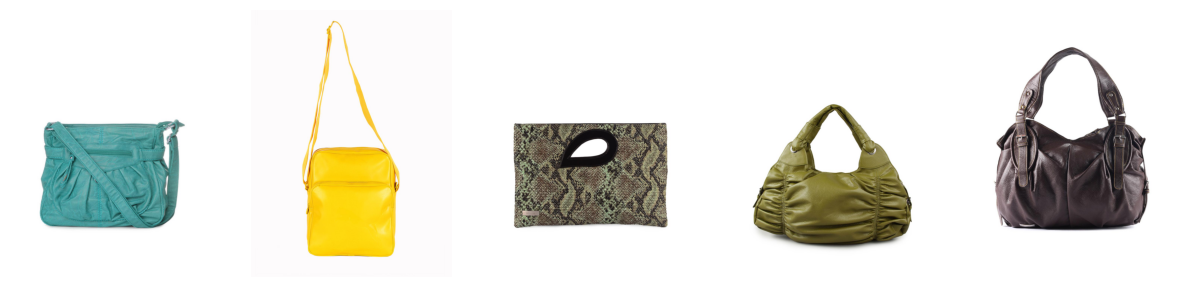

In [49]:
recommendations(ext1)

## Example .2

In [50]:
q = os.path.join(base, df['image'][44300])
ex2 = search(q, k=5)

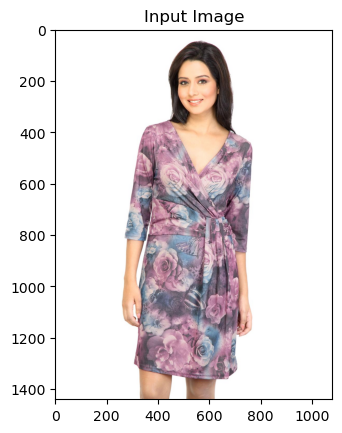

In [51]:
plot(q)

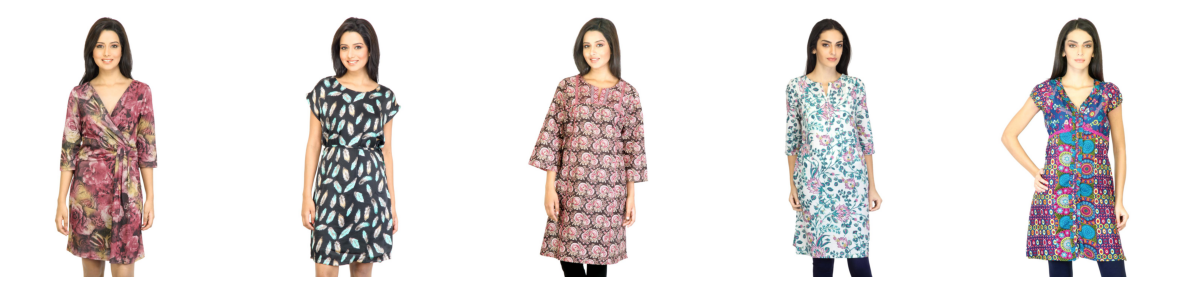

In [52]:
recommendations(ex2)

In [53]:
q_text = 'perfumes'
ext2 = search(q_text=q_text)

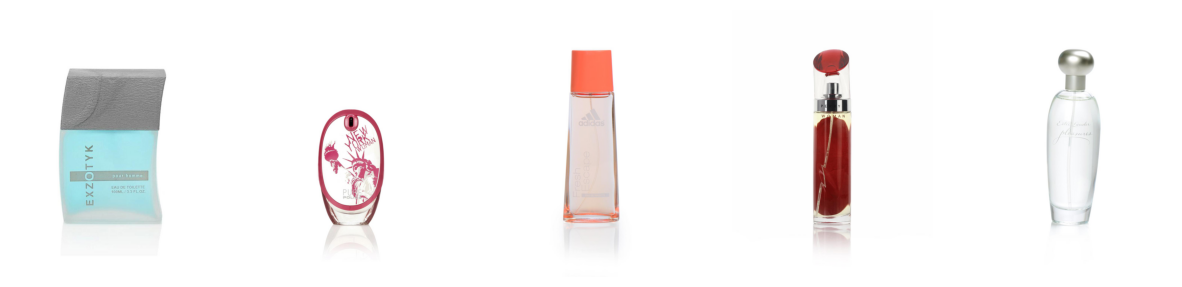

In [54]:
recommendations(ext2)

## Example .3

In [65]:
q = os.path.join(base, df['image'][38310])
ex3 = search(q, k=5)

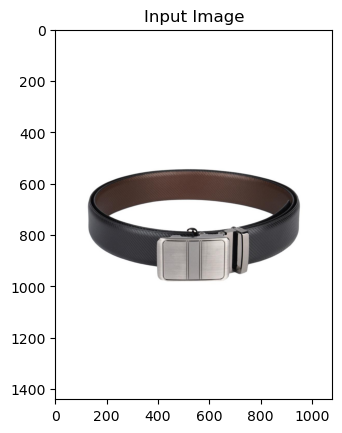

In [66]:
plot(q)

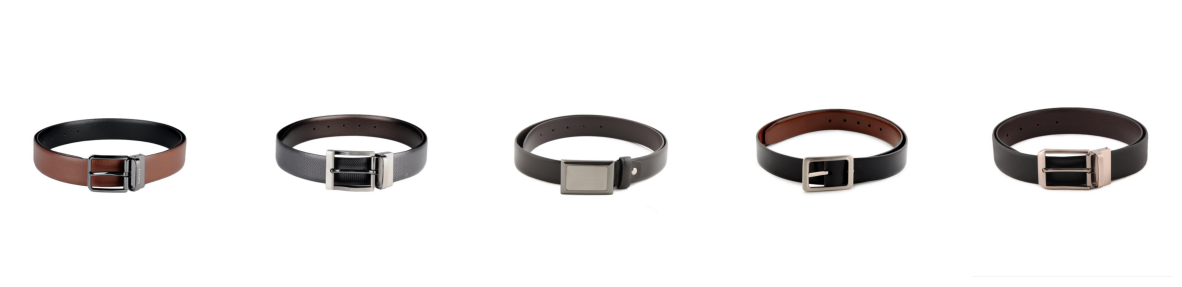

In [67]:
recommendations(ex3)

In [76]:
q_text = 'shoes'
ext3 = search(q_text=q_text)

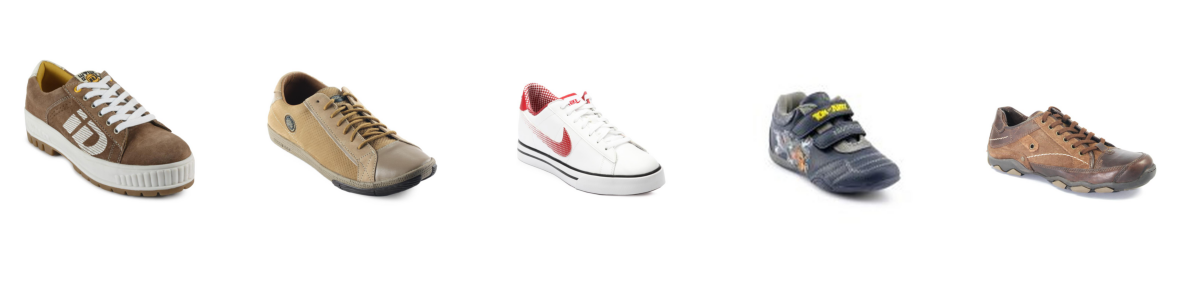

In [77]:
recommendations(ext3)